In [4]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import kwant.continuum
import dask.bag as db
from scipy.constants import electron_mass, hbar
import ccode.tools as tl
import scipy.sparse.linalg as sla
import time
import dask.bag as db
from dask_quantumtinkerer import Cluster, cluster_options
import itertools as it


/opt/conda/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


### Cluster configuration

In [2]:
options = cluster_options()
options.worker_cores = 1  # you should always leave this to 1 (I think)
options.worker_memory = 2  # Need to atdjust this to meet your needs
options.extra_path = "/home/jtorresluna/work/trijunction_design/"  # Make sure to do this if you import any local modules!

In [3]:
cluster = Cluster(options)

In [4]:
cluster

In [5]:
print(
    "http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"
    + cluster.dashboard_link[17:]
)

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/f4a757adaf624a2fba47d3014dc2a9fb/status


In [6]:
client = cluster.get_client()

In [109]:
cluster.close()

## Calculation of topological phase in the nanowire sub bands

In [5]:
bare_wire_hamiltonian = """
    ( t * (k_x**2 + k_y**2 ) - mu )*sigma_0
    + alpha * (k_x * sigma_y + k_y * sigma_x)
    + B_x * sigma_x
"""


def wire_parameters(m, bx):
    a = 10e-9
    t = hbar ** 2 / (2 * 0.023 * electron_mass) * (6.24e18)
    alpha = 0.3e-10
    parameters = dict(mu=(m), t=t, alpha=alpha, B_x=bx, a=a)
    return parameters


In [6]:
params_wire = wire_parameters(m=0, bx=0)
a = params_wire['a']
wire_width = 7*a

In [7]:
template_bare = kwant.continuum.discretize(bare_wire_hamiltonian, grid=a)
lead = kwant.Builder(symmetry=kwant.TranslationalSymmetry([-a, 0]))
w_nw = wire_width
lead.fill(template_bare, shape=lambda site: 0 <= site.pos[1] < w_nw, start=[0]);

fig, ax = plt.subplots()
kwant.plotter.bands(lead.finalized(), show=False, params=params_wire, ax=ax)
plt.close()

bands = []
for line in ax.lines:
    band_data = line.get_data()
    len_band = len(band_data[1])
    effective_mu = band_data[1][len_band // 2]
    bands.append(effective_mu)

bands = bands[:-1:2]

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [8]:
def topological_field(Delta, mu_shift):
    topo_B = np.sqrt(Delta**2 + (mu_shift-2*params['t']/(a**2))**2)
    return topo_B

toological_field = np.vectorize(topological_field)

### Finite system

In [9]:
hamiltonian = """( t * (k_x**2 + k_y**2 ) - mu_nw )* kron(sigma_0, sigma_z)
+ alpha * k_x * kron(sigma_y, sigma_z)
- alpha * k_y * kron(sigma_x, sigma_z)
+ Delta * kron(sigma_0, sigma_x)
+ B_x * kron(sigma_x, sigma_0)"""

template = kwant.continuum.discretize(hamiltonian, grid=a)

/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(
/opt/conda/lib/python3.9/site-packages/sympy/__init__.py:672: SymPyDeprecationWarning: 

importing sympy.matrices.matrices with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.matrices.matrices
instead. See https://github.com/sympy/sympy/issues/18245 for more
info.

  self.Warn(


In [10]:
def interval_shape(L, W):
    def shape(site):
        return 0 <= site.pos[0] < L and 0 <= site.pos[1] < W
    return shape


def make_wire(**params):
    wire = kwant.Builder()
    wire.fill(template, shape=interval_shape(params['L'], params['W']), start=[0])
    return wire.finalized()


def junction_parameters(m_nw, m_qd, bx):
    """
    Typical parameters
    """

    a = 10E-9
    t = hbar**2/(2*0.023*electron_mass)*(6.24E18)
    alpha = 0.4E-10
    Delta = 0.01
    parameters = dict(mu_nw=m_nw,
                      t=t,
                      Delta=Delta,
                      alpha=alpha,
                      B_x=bx,
                      a=a)
    return parameters

In [39]:
geometry_single_wire = {"L": 120*a, "W": wire_width}
wire = make_wire(**geometry_single_wire)

In [40]:
Bs = np.linspace(0.00, 0.001, 20)
key = 'B_x'
n = 6
eigen_single_wire = tl.solver(n=n, key=key)

In [41]:
def junction_parameters(m_nw, m_qd, bx):
    """
    Typical parameters
    """

    a = 10E-9
    t = hbar**2/(2*0.023*electron_mass)*(6.24E18)
    alpha = 0.3E-10
    Delta = 5E-4
    parameters = dict(mus_nw=m_nw,
                      mu_qd=m_qd,
                      t=t,
                      Delta=Delta,
                      alpha=alpha,
                      B_x=bx,
                      phi1=0,
                      phi2=0,
                      a=a)
    return parameters

In [42]:
params = junction_parameters(m_nw=0, m_qd=0, bx=0)

In [43]:
def wrap(args):
    return eigen_single_wire(*args)


def identity(**arg):
    return arg

In [44]:
parameters = []
for mu in bands:
    p = params.copy()
    p.update(mu_nw=mu)
    parameters.append(p)

In [45]:
%%time
args_sw = list(it.product([[wire, identity]], Bs, parameters))
db_args_sw = db.from_sequence(args_sw, npartitions=20)
result_sw = db_args_sw.map(wrap).compute()
en, wf = tl.separate_energies_wfs(result_sw)

CPU times: user 1.01 s, sys: 158 ms, total: 1.17 s
Wall time: 21.6 s


In [46]:
energies_bs = [[] for i in range(len(bands))]
for i in range(len(bands)*len(Bs)):
    energies_bs[i%len(bands)].append(en[i])
energies_bs = np.array(energies_bs)

In [47]:
Delta = params['Delta']
fields = topological_field(Delta=Delta, mu_shift=np.array(bands))

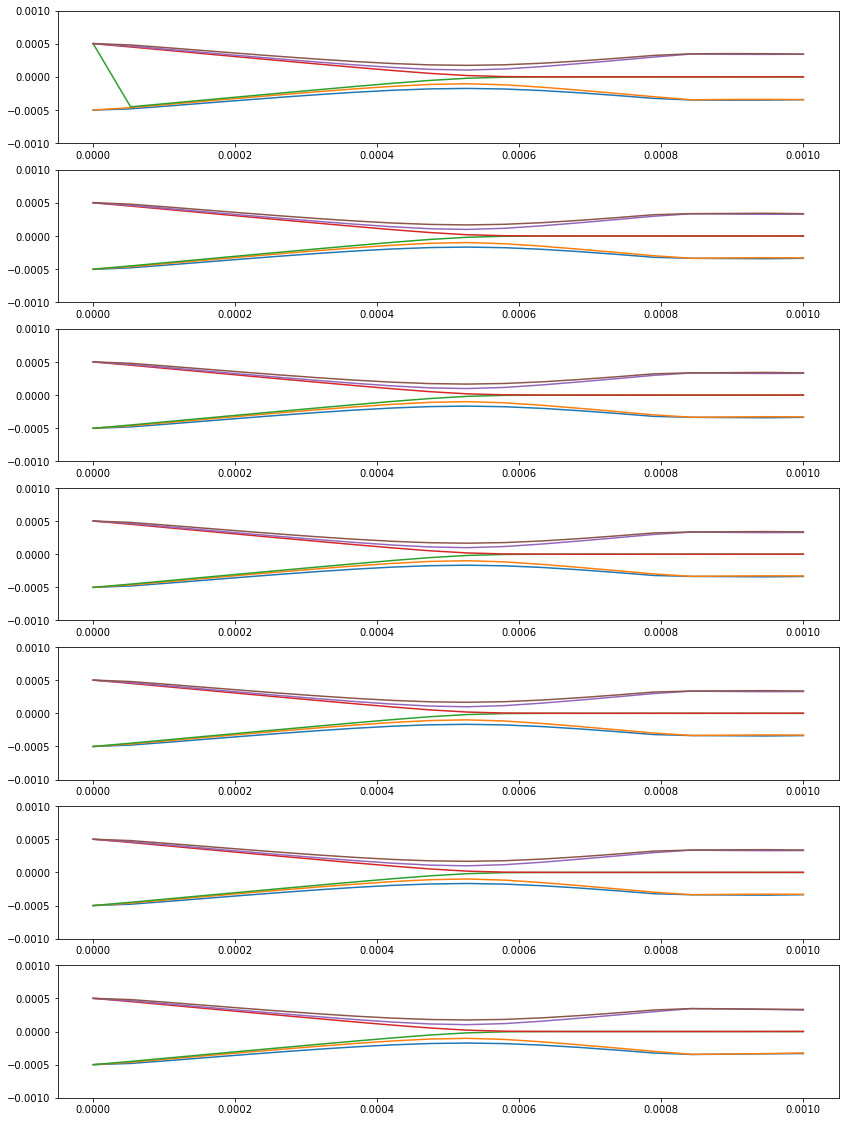

In [48]:
fig, axes = plt.subplots(ncols=1, nrows=len(bands), figsize=(14, 20))
i = 0
colors = ['black' for i in range(len(bands))]
colors[n//2] = 'red'
colors[n//2-1] = 'red'
for ax in axes:
    ax.plot(Bs, energies_bs[i])
    ax.set_ylim(-0.001, 0.001)
#    ax.vlines(x=fields[i], ymin=-1, ymax=1)
    i += 1

In [56]:
vals = []
vecs = []
for i in range(len(bands)):
    params.update(mu_nw = bands[i])
    params.update(B_x = 0.001)
    ham = wire.hamiltonian_submatrix(sparse=True, params=params)
    val, vec = tl.sort_eigen(sla.eigsh(ham, k=2, sigma=0))
    vals.append(val)
    vecs.append(vec)

In [57]:
density = kwant.operator.Density(wire, np.eye(4))

/tmp/ipykernel_2327/3736341611.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(wire, density(vecs[i][0]), ax=ax);
/tmp/ipykernel_2327/3736341611.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  kwant.plotter.density(wire, density(vecs[i][0]), ax=ax);
/tmp/ipykernel_2327/3736341611.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' 

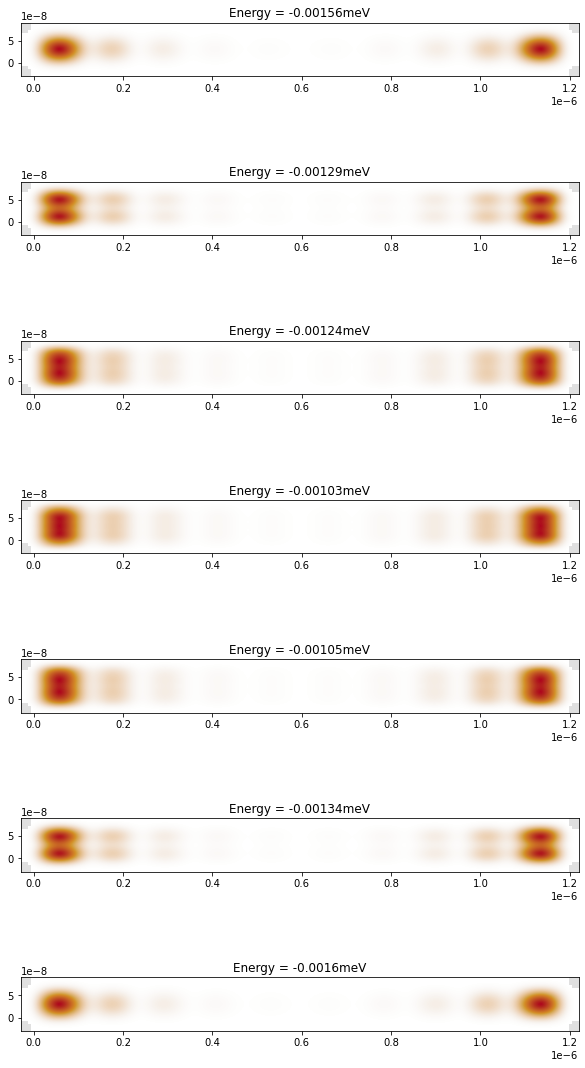

In [58]:
fig, axes = plt.subplots(nrows=len(bands), ncols=1, figsize=(10, 20))
i = 0
for ax in axes.flatten():
    kwant.plotter.density(wire, density(vecs[i][0]), ax=ax);
    ax.set_title('Energy = '+str(np.round(vals[i][0]*1000, 5))+'meV')
    i += 1

In [52]:
bands

[0.0023960204649275973,
 0.009605416498312178,
 0.020395040147213304,
 0.03312226901926766,
 0.045849497891322026,
 0.056639121540223145,
 0.06384851757360771]